# openEO use cases

This notebooks gives a tour of common cases supported by the openEO platform.


## Data preprocessing

### ARD generation

'Analysis ready data' is what you need at some point in any use case.
In openEO, you can either load a collection that has already been processed, or you can start from raw data. Usually, only the raw (L1C) data is only available for the full archive.

For examples:
- TERRASCOPE_S2_TOC_V2 contains Sentinel-2 L2A data processed with Sen2Cor, but only covering Europe and selected areas, limited in time.
- SENTINEL2_L1C_SENTINELHUB is global Sentinel-2 L1C data
- SENTINEL2_L2A_SENTINELHUB is global Sentinel-2 L2A, but not the complete archive
- SENTINEL1_GRD is a full Sentinel-1 GRD archive, which always requires ARD preprocessing to be usable

This showcase only highlights a few ARD features. A more complete description is available here:

https://open-eo.github.io/openeo-python-client/ard.html



In [100]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import pathlib

import openeo
from openeo.processes import eq, if_, lt,median
from shapely.geometry import box, mapping, shape
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [96]:

DEFAULT_FIGSIZE = (9, 6)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)        
        data = np.moveaxis(data, 0, 2)
        if data.shape[2]<3:
            data = data[:,:,0]
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax,cmap="RdYlGn")
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)
        

def plot_timeseries(filenames):
    """Helper to plot the timeseries directly from JSON file"""
    fig, ax = plt.subplots(figsize=(18,6))
    ax.set_title("B04"); ax.set_ylabel("B04");ax.set_ylim(0, 2000)
    for filename in filenames:
        with open(filename) as f:
            ts = timeseries_json_to_pandas(json.load(f)).dropna()
        ts.index = pd.to_datetime(ts.index)    
        ts.plot(marker='o', ax=ax, label=filename)
    
    ax.legend(title="parcel id", loc="lower left", ncol=2)

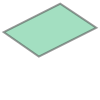

In [49]:
test_polygon = shape(json.loads("""
{
        "type": "Polygon",
        "coordinates": [
          [
            [
              3.9168834686279292,
              51.35114702549738
            ],
            [
              3.9218187332153325,
              51.3477161648989
            ],
            [
              3.929886817932129,
              51.35176348103484
            ],
            [
              3.9248228073120117,
              51.35514043810887
            ],
            [
              3.9168834686279292,
              51.35114702549738
            ]
          ]
        ]
      }
"""))
test_polygon

## Connecting
Connecting and authentication is explained here:

https://docs.terrascope.be/#/Developers/WebServices/OpenEO/OpenEO?id=logging-in

In [1]:

c = openeo.connect("openeo-dev.vito.be").authenticate_oidc("egi")

Authenticated using refresh token.


In [ ]:
c.list_collections()

### SAR backscatter

Here we show how to compute SAR backscatter with various parameters.

This depends on GRD data, which is coming from SentinelHub, and is also available on the CreoDIAS backend.

In [25]:
collection      = 'SENTINEL1_GRD'
bbox            = [3.758216409030558, 51.291835566, 4.087806252, 51.3927399]
bbox_poly       = box(minx=bbox[0],maxx=bbox[2],miny=bbox[1],maxy=bbox[3]) # Necessary for aggregate_spatial process
spatial_extent = {'west': 3.758216409030558, 'east': 4.087806252, 'south': 51.291835566, 'north': 51.3927399,
                      'crs': 'EPSG:4326'}
temporal_extent = ["2020-05-05", "2020-05-05"]
bands           = ["VV","VH"]

properties = {"orbitDirection": lambda od: eq(od, "ASCENDING")} ## Orbit direction filtering

s1 = c.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent,properties=properties)

The **sar_backscatter** process offer multiple parameters that can be used depending on the application needs: https://processes.openeo.org/draft/#sar_backscatter
For example, we could choose among the following coefficients:
- **beta0**:            radar brightness
- **sigma0-ellipsoid**: ground area computed with ellipsoid earth model
- **sigma0-terrain**:   ground area computed with terrain earth model
- **gamma0-ellipsoid**: ground area computed with ellipsoid earth model in sensor line of sight
- **gamma0-terrain**:   ground area computed with terrain earth model in sensor line of sight (default)
- **null**:             non-normalized backscatter

Timeseries extraction can help to show where there is relevant data:

In [27]:
 s1.sar_backscatter(coefficient="gamma0-terrain").polygonal_mean_timeseries(bbox_poly).execute()

{'2020-05-05T00:00:00Z': [[0.12630434190821418, 0.015680065340919307]],
 '2020-05-06T00:00:00Z': [[0.07191087146282442, 0.011256123502264204]]}

In [28]:
s1.sar_backscatter(coefficient="gamma0-terrain").download("gamma0.tiff")

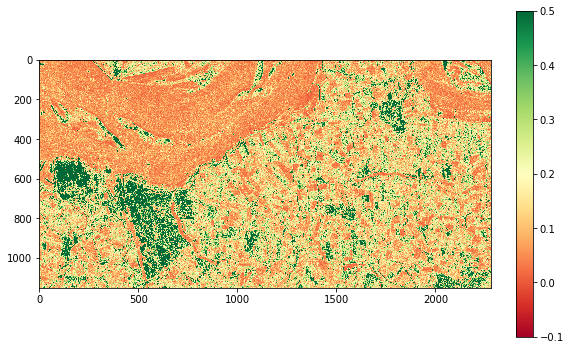

In [39]:
show_tiff("gamma0.tiff", vmin=-0.1, vmax=0.5, add_colorbar=True)

### Optical ARD comparison

In this case, we'll do a comparison of Sentinel-2 band B04, corrected with 3 different algorithms.
We use an aggregated timeseries over a homogeneous area for this test.

In [55]:
bands           = ["B04","CLP",'B09','B8A','B11','sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean']

l1c_bands = c.load_collection('SENTINEL2_L1C_SENTINELHUB',bands=bands,temporal_extent=["2020-01-01","2021-01-01"])

The cell below contains the actual atmospheric correction. Here we only specify the method to use.

In [74]:
%%time
icor = l1c_bands.atmospheric_correction(method='iCor')
smac = l1c_bands.atmospheric_correction(method='smac')

CPU times: user 59 µs, sys: 17 µs, total: 76 µs
Wall time: 83 µs


#### Cloud masking

Another important part to achieve ARD, is cloud masking, here we use cloud masks available on Sentinelhub.

In this function, we only return one band, so others are filtered out.

In [111]:
from openeo.processes import ProcessBuilder, lt
def mask(value:ProcessBuilder):    
    red = value.array_element(0)
    clm = value.array_element(1)    
    
    return if_(lt(clm,40),red)

#### Retrieving ARD timeseries

In [85]:
%%time
icor.reduce_dimension(dimension="bands",reducer = mask ).aggregate_spatial(test_polygon,reducer="median").download("icor.json",format="JSON")
smac.reduce_dimension(dimension="bands",reducer = mask ).aggregate_spatial(test_polygon,reducer="median").download("smac.json",format="JSON")

CPU times: user 25.2 ms, sys: 4.8 ms, total: 30 ms
Wall time: 4min 45s


In [112]:
%%time
sen2cor = c.load_collection('SENTINEL2_L2A_SENTINELHUB',bands=["B04","CLP"],temporal_extent=["2020-01-01","2021-01-01"]).reduce_dimension(dimension="bands",reducer = mask )
sen2cor.aggregate_spatial(test_polygon,reducer="median").download("sen2cor.json",format="JSON")

CPU times: user 8.46 ms, sys: 1.64 ms, total: 10.1 ms
Wall time: 32 s


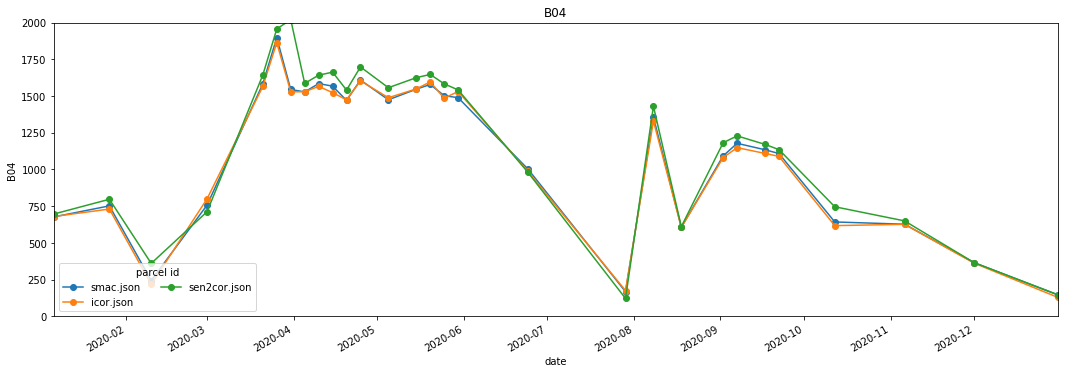

In [97]:
plot_timeseries(["smac.json","icor.json","sen2cor.json"])

# Integrating custom Python code

Very often, users already have existing Python code that they want to reuse, or use an open source library like Tensorflow to apply a machine learning model.

For a more detailed explanation, the [manual](https://open-eo.github.io/openeo-python-client/udf.html) can be used.

In this example, we will first aggregate our observations in time, to get evenly spaced timesteps. 

After that, the Savitzky Golay smoother from scipy will be applied.

In [113]:
intervals = [['2020-01-01T00:00:00', '2020-01-11T00:00:00'], ['2020-01-11T00:00:00', '2020-01-21T00:00:00'], ['2020-01-21T00:00:00', '2020-01-01T00:00:00'], ['2020-02-01T00:00:00', '2020-02-11T00:00:00'], ['2020-02-11T00:00:00', '2020-02-21T00:00:00'], ['2020-02-21T00:00:00', '2020-02-01T00:00:00'], ['2020-03-01T00:00:00', '2020-03-11T00:00:00'], ['2020-03-11T00:00:00', '2020-03-21T00:00:00'], ['2020-03-21T00:00:00', '2020-03-01T00:00:00'], ['2020-04-01T00:00:00', '2020-04-11T00:00:00'], ['2020-04-11T00:00:00', '2020-04-21T00:00:00'], ['2020-04-21T00:00:00', '2020-04-01T00:00:00'], ['2020-05-01T00:00:00', '2020-05-11T00:00:00'], ['2020-05-11T00:00:00', '2020-05-21T00:00:00'], ['2020-05-21T00:00:00', '2020-05-01T00:00:00'], ['2020-06-01T00:00:00', '2020-06-11T00:00:00'], ['2020-06-11T00:00:00', '2020-06-21T00:00:00'], ['2020-06-21T00:00:00', '2020-06-01T00:00:00'], ['2020-07-01T00:00:00', '2020-07-11T00:00:00'], ['2020-07-11T00:00:00', '2020-07-21T00:00:00'], ['2020-07-21T00:00:00', '2020-07-01T00:00:00'], ['2020-08-01T00:00:00', '2020-08-11T00:00:00'], ['2020-08-11T00:00:00', '2020-08-21T00:00:00'], ['2020-08-21T00:00:00', '2020-08-01T00:00:00'], ['2020-09-01T00:00:00', '2020-09-11T00:00:00'], ['2020-09-11T00:00:00', '2020-09-21T00:00:00'], ['2020-09-21T00:00:00', '2020-09-01T00:00:00'], ['2020-10-01T00:00:00', '2020-10-11T00:00:00'], ['2020-10-11T00:00:00', '2020-10-21T00:00:00'], ['2020-10-21T00:00:00', '2020-10-01T00:00:00'], ['2020-11-01T00:00:00', '2020-11-11T00:00:00'], ['2020-11-11T00:00:00', '2020-11-21T00:00:00'], ['2020-11-21T00:00:00', '2020-11-01T00:00:00'], ['2020-12-01T00:00:00', '2020-12-11T00:00:00'], ['2020-12-11T00:00:00', '2020-12-21T00:00:00'], ['2020-12-21T00:00:00', '2020-12-01T00:00:00']]
labels = [i[0] for i in intervals]
composite = sen2cor.aggregate_temporal(intervals=intervals,labels=labels, reducer=median)
%time composite.aggregate_spatial(test_polygon,reducer="median").download("l2a_composite",format="JSON")

CPU times: user 5.85 ms, sys: 2.19 ms, total: 8.03 ms
Wall time: 29.8 s


In [115]:
udf_code = """
from scipy.signal import savgol_filter
from openeo_udf.api.datacube import DataCube

def apply_datacube(cube: DataCube, context: dict) -> DataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""

smoothed=composite.apply_dimension(code=udf_code, runtime="Python", dimension="t")
smoothed.aggregate_spatial(test_polygon,reducer="median").download("smoothed",format="JSON")

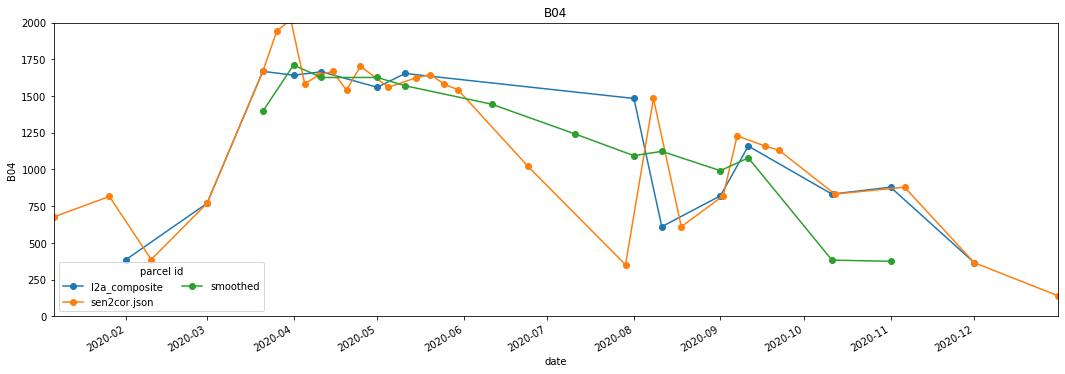

In [116]:
plot_timeseries(["l2a_composite","sen2cor.json","smoothed"])

# Higher level functions

For some users, doing low-level EO timeseries analysis is not their primary goal.
Instead, they like to retrieve higher level information, like crop calendars or biomass in the case of agriculture.

To enable this, openEO exposes a growing collection of ["user defined processes"](https://open-eo.github.io/openeo-python-client/udp.html), contributed by our community.

As this is a feature under development, we currently can only show those processes through a URL:
https://openeo.vito.be/openeo/1.0/processes/vito
